<span style="font-size:x-large;">Lab 4: Mini-Assignment</span>

# Census Lab Assignment

## Task

Investigate a question of your choosing about a population from the 2016 Census data provided by the Australian Bureau of Statistics (ABS), and present your findings, as discussed in the accompanying assignment sheet.

---

### Context

## Exploring the Gender Pay Gap Between Censuses

According to the Workplace Gender Equality Agency (WGEA) (an Australian Government Statutory Agency) the gender pay gap (GPG) was at its highest (between 1999 - 2019) in November 2014 at 18.5% (https://www.wgea.gov.au/data/fact-sheets/australias-gender-pay-gap-statistics-2020).

This date sits nicely between the 2011 and 2016 censuses. Therefore the GPG must have increased between the 2011 census and November 2014. 

At the time, Australia's Minister for Women was none other than Tony Abbott, famously not a woman. https://www.smh.com.au/opinion/tony-abbott-minister-for-women-no-thanks-20130919-2u179.html

However, after the 2015 leadership spill Michaelia Cash, a woman, was promoted from assisting the Minister for Women to the Minister herself. Her tenure included the 2016 census.

## So between November 2014 and the 2016 census, did the GPG manage to recover to levels seen in the 2011 census?

To investigate, I will be calculating the proportion of females within each weekly income bracket documented in the 2011 and 2016 censuses.

Through data visualisation we will be able to see whether these proportions approach, or move further away from 0.5 (50%), the value you would expect if there were an equal number of males and females within each income bracket.




### Data Aquisition

To conduct the analysis I will be using "Total Personal Income (Weekly) by Age by Sex" tables within datapacks from https://datapacks.censusdata.abs.gov.au/datapacks/:

- The 2011 "Basic Community Profile" Datapack (Geography = "Australia", Descriptor Type = "Short Header")
     - Tables:
         - B17A
         - B17B

- The 2016 "General Community Profile" Datapack (Geography = "Australia")
    - Tables:
        - G17A
        - G17B
        - G17C


In [1]:
file_names_2011 = ["./data/2011/2011Census_B17A_AUST_short.csv", 
                   "./data/2011/2011Census_B17B_AUST_short.csv"] # CHANGE THIS WHEN MOVING TO COCALC

file_names_2016 = ["./data/2016/2016Census_G17A_AUS.csv",
                   "./data/2016/2016Census_G17B_AUS.csv",
                   "./data/2016/2016Census_G17C_AUS.csv"]  # CHANGE THIS WHEN MOVING TO COCALC


The first line in each file contains all the headings and the second line contains all the counts.

create_data_lists() is used to read the data from all the files for a census year into a 2-D list. 

For each file for the given year we concatenate the headings and counts to the 0th and 1st index of the list respectively.

We are then left with a 2-D list containg headings and counts for both the census year.

I have then checked to make sure we have the same number of headings as we do counts for both years. 

In [2]:
# Read in data
def read_data(file_name):
    lines = []

    with open(file_name, 'r') as infile:
        for line in infile:
            lines.append(line.strip().split(','))

    return (lines[0], lines[1])


def create_data_lists(file_name_list):
    data = [[], []]     #[ [headings], [count] ]

    for file_name in file_name_list:
        file_data = read_data(file_name)
        data[0] += file_data[0]
        data[1] += file_data[1]

    return data


data_lists_2011 = create_data_lists(file_names_2011)
data_lists_2016 = create_data_lists(file_names_2016)

# Check lengths to make sure we have same number of headings as count values
# Should both be True
print(len(data_lists_2011[0]) == len(data_lists_2011[1])) 
print(len(data_lists_2016[0]) == len(data_lists_2016[1]))


True
True


### Data Cleaning/Conversion
Now that we've read in all the data from the files, we need to extract only the relevant parts.

To compute a proportion of gender for each income bracket we really only need the totals counts for each gender in each bracket. 

So any data ascociated with:
- Gender by age

- Income not stated

- Totals of population

have been removed.


In clean_by_gender() as well as removing unwanted data, we also convert the data to a more readable/usable form.

For example with the header "m_1249_1499_tot" we:
- Remove the "_tot" as we know they will all be totals

- Remove the "(m/f)_" from the front as dictionary key will keep track of what gender the data is related to

- Replace the "_" joing the range of income with "-" for style

The count data is then also converted to an integer value.

What we are left with is a seperate dictionary for 2011 and 2016.

The dictionaries have keys for each gender which point to another dictionary that contains (heading: count) pairs for each income bracket.

In [3]:
def clean_by_gender(data_lists):
    genders = ['m', 'f']
    cleaned_data = dict([(gender, {}) for gender in genders])

    for header, count in zip(data_lists[0], data_lists[1]):
        header = header.lower()

        if (header[0] in genders) and ('tot' in header):
            key = header[0]

            if not any(substring in header for substring in ['ns', 'yrs', '85ov', 'tot_tot']):
                if 'nil' in header:
                    header = '0-0'
                else:
                    header = header.replace('_tot', '').replace(key + '_', '').replace('_', '-')
                cleaned_data[key][header] = int(count)

    return cleaned_data


cleaned_data_2011 = clean_by_gender(data_lists_2011)
cleaned_data_2016 = clean_by_gender(data_lists_2016)


#### A Clarification on Removing Not Stated Incomes

As we are looking at proportions within income brackets, and not measures of central tendancy simply removing the unstated data seems like the easiest course of action.

As sample size does not directly affect a proportion, like it would the for example the mean, as long as the sample proportion is indicative of the population proportion. 

That is to say, if a disproportionate amount of 1 gender decided not to disclose their income then our sample proportions would not be accurate.

So let's check:

In [4]:
def get_not_stated(data_lists):
    genders = ['m', 'f']
    not_stated_data = dict([(gender, {}) for gender in genders])

    for header, count in zip(data_lists[0], data_lists[1]):
        header = header.lower()

        if (header[0] in genders) and ('tot' in header) and ('ns' in header):
            key = header[0]
            not_stated_data[key][header] = int(count)
    
    return not_stated_data


def get_female_proportion(data_dict):
    for key_m, key_f in zip(data_dict['m'].keys(), data_dict['f'].keys()): # there is only 1 key for both
        ns_female_2011 = data_dict['f'][key_f]
        ns_male_2011   = data_dict['m'][key_m]
        proportion     = ns_female_2011 / (ns_female_2011 + ns_male_2011)

    return proportion


not_stated_2011 = get_not_stated(data_lists_2011)
not_stated_2016 = get_not_stated(data_lists_2016)

proportion_female_ns = []
proportion_female_ns.append(get_female_proportion(not_stated_2011))
proportion_female_ns.append(get_female_proportion(not_stated_2016))

print("Proportion of people who did not repspond that are female:")
print("2011: {:.1%}".format(proportion_female_ns[0]))
print("2016: {:.1%}".format(proportion_female_ns[1]))


Proportion of people who did not repspond that are female:
2011: 47.3%
2016: 49.6%


As we can see from the output above, in 2011, 47.3% of people who did not state their income were female.

In 2016, this figure increased to 49.6%.

So I think it is safe to assume that an equal amount of male and females have given a not stated response.

#### Back to Data Cleaning/Conversion
Interestingly though, the 2011 and 2016 appear to use a different set of ranges for income brackets.

In [5]:
print("Number of headings 2011: {}".format(len(cleaned_data_2011['m'])))
print("Number of headings 2016: {}".format(len(cleaned_data_2016['m'])))


Number of headings 2011: 11
Number of headings 2016: 14


Lets have a look at what the headings for each census are...

In [6]:
import itertools

print("(2011 Header, 2016 Header)")

for header2011, header2016 in list(itertools.zip_longest(cleaned_data_2011['m'].keys(), cleaned_data_2016['m'].keys())):
    if header2011 is None:
        header2011 = "N/A"
    print("({:<11}, {:>11})".format(header2011, header2016))


(2011 Header, 2016 Header)
(0-0        ,         0-0)
(1-199      ,       1-149)
(200-299    ,     150-299)
(300-399    ,     300-399)
(400-599    ,     400-499)
(600-799    ,     500-649)
(800-999    ,     650-799)
(1000-1249  ,     800-999)
(1250-1499  ,   1000-1249)
(1500-1999  ,   1250-1499)
(2000-more  ,   1500-1749)
(N/A        ,   1750-1999)
(N/A        ,   2000-2999)
(N/A        ,   3000-more)


Clearly the 2011 and 2016 use different schemes for seperating income brackets.

However, we could merge some of the ranges in each dictionary so that both sets of data share the same scheme.

- 2011 Merge(1-199, 200-299)            -> 1-299
- 2016 Merge(1-149, 150-299)            -> 1-299

- 2011 Merge(400-599, 600-799)          -> 400-799
- 2016 Merge(400-499, 500-649, 650-799) -> 400-799

- 2016 Merge(1500-1749, 1750-1999)      -> 1500-1999

- 2016 Merge(2000-2999, 3000-more)      -> 2000-more

Doing so would leave us with the ranges displayed in the function squash_ranges() below for both the 2011 and 2016 data. 

In [7]:
def squash_ranges(old_dict):
    keys = ['0-0',         '1-299',     '299-399',
            '400-799',   '800-999',   '1000-1249',
            '1250-1499', '1500-1999', '2000-more']

    new_dict = dict([(key, 0) for key in keys])

    for old_key in old_dict.keys():
        old_key_max = old_key.split('-')[1]

        if old_key_max == 'more':
            new_dict[keys[-1]] += old_dict[old_key]

        else:
            old_key_max = int(old_key_max)

            range_found = False
            keys_idx = 0

            while not range_found:
                new_key_max = keys[keys_idx].split('-')[1]
                if new_key_max == 'more' or old_key_max <= int(new_key_max):
                    new_dict[keys[keys_idx]] += old_dict[old_key]
                    range_found = True
                else:
                    keys_idx += 1

    return new_dict


for key in cleaned_data_2011.keys():
    cleaned_data_2011[key] = squash_ranges(cleaned_data_2011[key])
    cleaned_data_2016[key] = squash_ranges(cleaned_data_2016[key])


### Data Analysis/Interpretation

Right now we have the counts of males and females for each income bracket.

What we really want is the proportion of people who are female for each income bracket.

We start with an empty dictionary with 2 keys '2011' and '2016'.

For each of these keys we assign another dictionary of (income bracket, proportion that are female) key/value pairs. 
- Proportion that are female = number of females in bracket / (number of females in bracket + number of males in bracket)

We now have for each census year and for each income bracket, the proportion of people that are female. 
 

In [8]:
def add_proportions(data):
    genders = list(data.keys())
    ranges = list(data[genders[0]].keys())

    proportions = dict([(r, 0) for r in ranges])

    for range_key in ranges:
        female_count = data['f'][range_key]
        male_count = data['m'][range_key]
        proportion = female_count / (female_count + male_count)
        proportions[range_key] = proportion

    return proportions


cleaned_data = [cleaned_data_2011, cleaned_data_2016]
years = ['2011', '2016']
proportions = dict([(year, {}) for year in years])

for year, data in zip(years, cleaned_data):
    proportions[year] = add_proportions(data)


If income between genders was equally spread, all of these proportions should be equal to 0.5 (50%).

That is, for each income bracket there is an equal number of males as there is females.

If the GPG in 2016 has recovered from its peak in November 2014 back to levels seen in the 2011 Census then we would expected the proportions of the 2011 data to be equal to those of the 2016 data.

To examine whether this is the case we can use visualisation...

### Data Visualisation

To compare the change in proportions from 2011 to 2016 we can use a grouped bar chart.

The horizontal green line through the chart shows where 0.5, the level of perfect equality is for each income bracket.

If 2011 and 2016 shared the same proportions we would expect the red and blue bars to have the same height for each level of income.

From 2011 to 2016 if the number of females became closer to number of males in an income bracket, we would expect the blue bar to be closer to the green bar than the red bar.

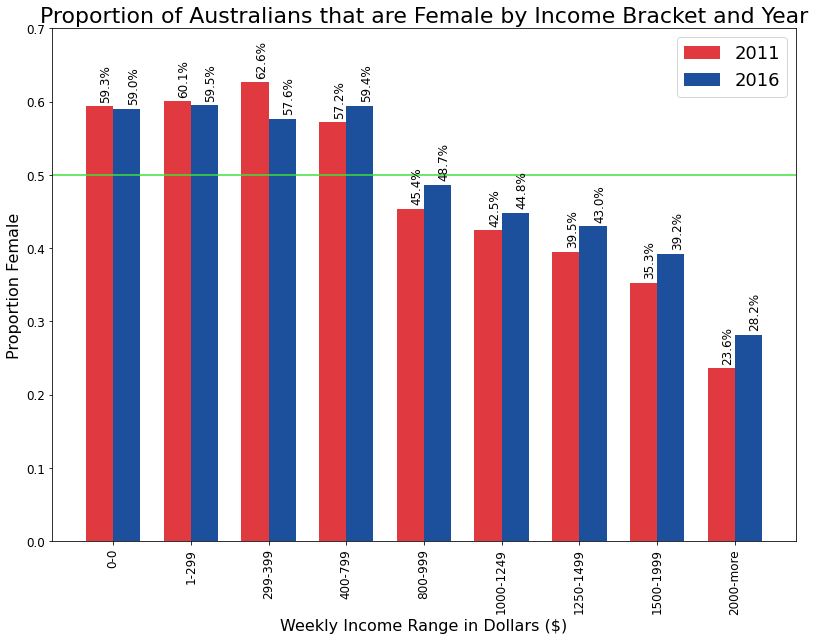

In [9]:
# PYTHON DICTIONARIES ORDERS ARE PRESERVED SINCE 3.6
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 9)) # ADJUST THIS IN COCALC
axes = plt.gca()
axes.set_ylim(0, 0.7)
bar_width = 0.35

x_values_2011 = list(proportions['2011'].values())
x_values_2016 = list(proportions['2016'].values())

x_ticks = list(proportions['2011'].keys())

range1 = list(range(0, len(x_values_2011)))
range2 = [x + bar_width for x in range1]

labor_red = '#e13940'       # not trying to get political
liberal_blue = '#1c4f9c'    # just needed a colour for each year
complimentary = '#3fe139'


bars2011 = plt.bar(range1, x_values_2011, color=labor_red, width=bar_width, label='2011')
bars2016 = plt.bar(range2, x_values_2016, color=liberal_blue,  width=bar_width, label='2016')

for rect in bars2011 + bars2016:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height+0.01, "{:.1%}".format(height), rotation=90, fontsize=12)

plt.axhline(y=0.5, color=complimentary, linestyle='-')

plt.xticks([x + bar_width / 2 for x in range1], x_ticks, fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(axis='x', labelrotation=90)
plt.ylabel("Proportion Female", fontsize=16)
plt.xlabel("Weekly Income Range in Dollars ($)", fontsize=16)
plt.title("Proportion of Australians that are Female by Income Bracket and Year", fontsize=22)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

From the above chart it appears that in 2016, 8/9 weekly income brackets grew closer to a 50/50 split between males and females when compared to 2011 census data.

In this time frame, it appears that the 5 highest income brackets became more equal than the 3/4 of the lowest. In 2016 the \$400-\$700 bracket actually saw an increase of 2.2% in the female count even though they already accounted for 57.2%, more than half, in 2011. 

However, the largest move towards 50% representation was in the \$299-\$399 which saw a 5% reduction in females. 

Interestingly, the second largest move towards the 50/50 line was the category with the least female representation and the highest \$/week income bracket, $2000+/week, which increased 4.6% between censuses.

As well as this 5 out of top 6 improved income brackets are actually the highest $/week brackets.
  

### Conclusion

By analysing data provided from the 2011 and 2016 censuses it seems the GPG did in fact recover from its peak in November 2014 back down to levels seen in the 2011 census. 

Evidently all but 1 proportion of female/male representation are at least as close to 50% in 2016 as they were in 2011. 

However, from the visualisation seen above it appears that the GPG in 2016 has probably even improved on the whole when compared to 2011 as 8/9 income brackets are actually closer to 50% female representation in 2016 than they were in 2011. 

In general it appears females increased their representation in higher $/week income brackets and reduced it in lower brackets (with of course 1 exception). 







### Declaration

This declaration should be completed and remain attached to the bottom of your submission.

*I am aware of the University’s [policy on academic conduct](https://www.governance.uwa.edu.au/procedures/policies/policies-and-procedures?method=document&id=UP07/21) and I declare that this assignment is my own work entirely and that suitable acknowledgement has been made for any sources of information used in preparing it. I have retained a hard copy for my own records.*

Name: Thomas Cleary

Date: 05/09/2020

---